In [2]:
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import datetime as dt
import tqdm
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

def get_lat_lon_barra():
        ta_file = nc.Dataset(glob.glob("/g/data/cj37/BARRA/BARRA_R/v1/analysis/prs/air_temp/"\
        +"2012"+"/"+"12"+"/air_temp-an-prs-PT0H-BARRA_R-v1-"+"2012"+"12"+"01"+"T"+"00"+"*.nc")[0])
        lon = ta_file["longitude"][:]
        lat = ta_file["latitude"][:]
        return [lon,lat]

def get_mask_barra(lon,lat):

        #Take 1d lat lon data from an already-loaded BARRA-R domain (e.g. sa_small or aus) and return a land-sea mask
        nat_lon,nat_lat = get_lat_lon_barra()
        lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
        lat_ind = np.where((nat_lat >= lat[0]) & (nat_lat <= lat[-1]))[0]
        lsm = nc.Dataset("/g/data/cj37/BARRA/BARRA_R/v1/static/lnd_mask-an-slv-PT0H-BARRA_R-v1.nc").variables["lnd_mask"][:]
        lsm_domain = lsm[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]

        return lsm_domain

def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def get_mask(lon,lat,thresh=0.5):
    #Return lsm for a given domain (with lats=lat and lons=lon)
    lsm,nat_lon,nat_lat = get_lsm()
    lon_ind = np.where((nat_lon >= lon[0]) & (nat_lon <= lon[-1]))[0]
    lat_ind = np.where((nat_lat >= lat[-1]) & (nat_lat <= lat[0]))[0]
    lsm_domain = lsm[(lat_ind[0]):(lat_ind[-1]+1),(lon_ind[0]):(lon_ind[-1]+1)]
    lsm_domain = np.where(lsm_domain > thresh, 1, 0)

    return lsm_domain

def get_lsm():
    #Load the ERA5 land-sea fraction
    lsm_file = nc.Dataset("/g/data/rt52/era5/single-levels/reanalysis/lsm/1979/lsm_era5_oper_sfc_19790101-19790131.nc")
    lsm = np.squeeze(lsm_file.variables["lsm"][0])
    lsm_lon = np.squeeze(lsm_file.variables["longitude"][:])
    lsm_lat = np.squeeze(lsm_file.variables["latitude"][:])
    lsm_file.close()
    return [lsm,lsm_lon,lsm_lat]


def cape_shear_data_era5(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/era5/era5_"\
                            +time.strftime("%Y%m")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        subset = f.isel_points("points",lat=a, lon=b)
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)


def cape_shear_data_barra(var, time, lat, lon, r=0, func=np.max):
    #print("\n",lat, lon, time)
    f = xr.open_dataset(glob.glob("/g/data/eg3/ab4502/ExtremeWind/aus/barra_fc/barra_fc_"\
                            +time.strftime("%Y%m%d")+"*.nc")[0])[var].sel({"time":time.replace(minute=0)})

    lats = f.coords.get("lat").values
    lons = f.coords.get("lon").values
    x,y = np.meshgrid(lons,lats)
    mask = get_mask_barra(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    if r>0:
        a,b = np.where( (dist_km <= r) & (mask==1) )
        subset = f.isel_points("points",lat=a, lon=b)
        sliced = subset.apply(func)
    else:
        dist_km = np.where(mask==1, dist_km, 9999)
        temp_lat,temp_lon = np.unravel_index(np.nanargmin(dist_km),dist_km.shape)
        sliced = f.isel({"lon":temp_lon, "lat":temp_lat})

    return pd.DataFrame({"var":[np.round(sliced[v].values,1) for v in var]}, index=var)


In [3]:
details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"2", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"2", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"2", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"2", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"2", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"2", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"2", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"2", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"2", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"71", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"71", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"71", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"71", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"71", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"71", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"71", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"71", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"71", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"66", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"66", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"50", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"50", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"66", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"50", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"50", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"66", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"50", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"27", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"27", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"27", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"27", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"27", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"27", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"27", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"27", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"27", "title":"i) "},\
         ]

var = ["rid","mu_cape","s06","dcape","Umean06"]
era5_df = pd.DataFrame(columns=var)
barra_df = pd.DataFrame(columns=var)
for details in tqdm.tqdm(details_list):
    temp_era5 = cape_shear_data_era5(["mu_cape","s06","Umean06","dcape"], details["time"][0], details["lat"], 
                         details["lon"], r=50, func=np.max).T
    temp_barra = cape_shear_data_barra(["mu_cape","s06","Umean06","dcape"], details["time"][0], details["lat"], 
                         details["lon"], r=50, func=np.max).T
    temp_barra["rid"]=details["rid"]
    temp_era5["rid"]=details["rid"]
    era5_df = pd.concat([era5_df,temp_era5])
    barra_df = pd.concat([barra_df,temp_barra])    

100%|██████████| 36/36 [00:59<00:00,  1.64s/it]


Text(0.5, 1.0, 'ERA5')

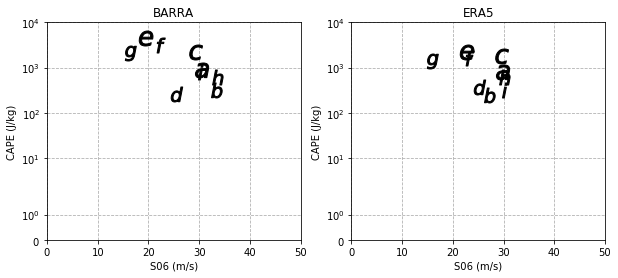

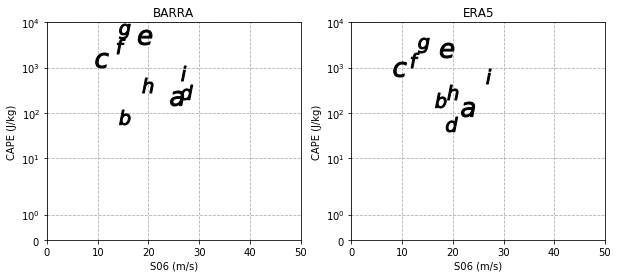

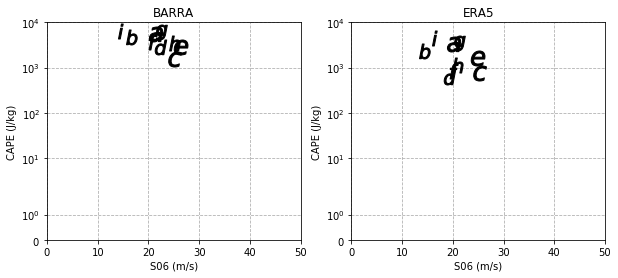

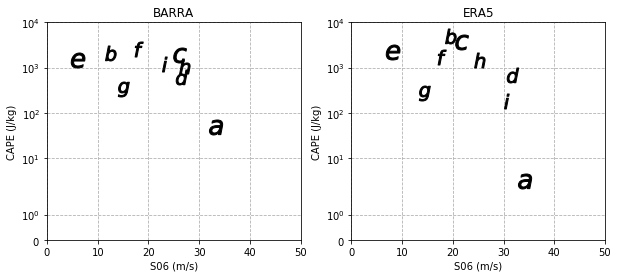

In [5]:
def plot(df, rids):
    letter = ["a","b","c","d","e","f","g","h","i"]
    temp_df = df[np.in1d(df.rid,rids)]
    for i in np.arange(temp_df.shape[0]):
        plt.plot(temp_df.iloc[i]["s06"],temp_df.iloc[i]["mu_cape"],marker="$"+letter[i]+"$",ls="none",
                 ms=15,mew=1,color="k")
    plt.xlabel("S06 (m/s)")
    plt.ylabel("CAPE (J/kg)")
    plt.gca().grid(ls="--")

    plt.yscale("symlog")
    plt.ylim([0,10000])
    plt.xlim([0,50])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["2"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["2"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["71"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["71"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["50","66"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["50","66"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["27"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["27"]); plt.title("ERA5")

Text(0.5, 1.0, 'ERA5')

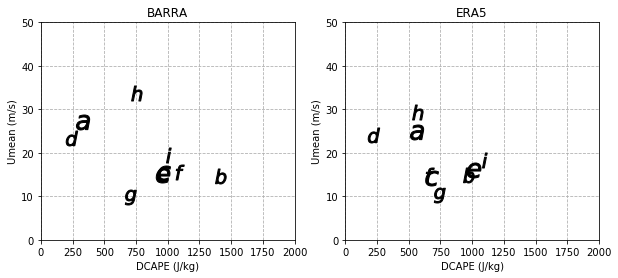

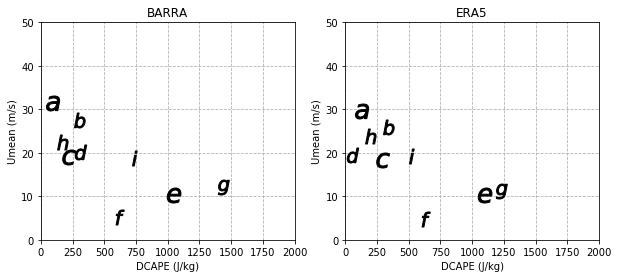

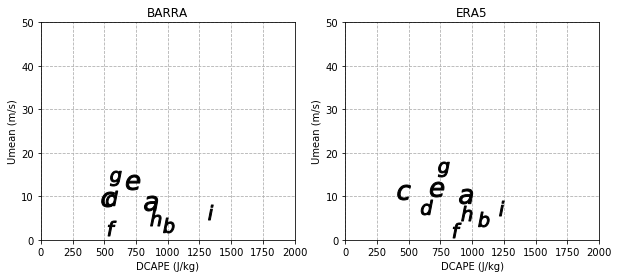

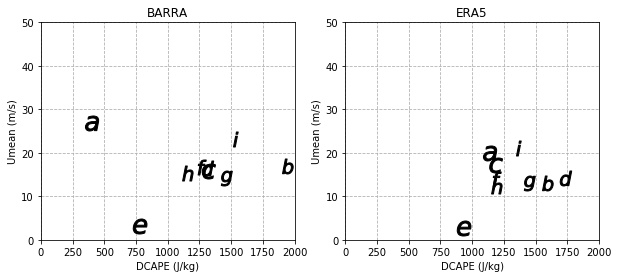

In [6]:
def plot(df, rids):
    letter = ["a","b","c","d","e","f","g","h","i"]
    temp_df = df[np.in1d(df.rid,rids)]
    for i in np.arange(temp_df.shape[0]):
        plt.plot(temp_df.iloc[i]["dcape"],temp_df.iloc[i]["Umean06"],marker="$"+letter[i]+"$",ls="none",
                 ms=15,mew=1,color="k")
    plt.xlabel("DCAPE (J/kg)")
    plt.ylabel("Umean (m/s)")
    plt.gca().grid(ls="--")

    plt.ylim([0,50])
    plt.xlim([0,2000])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["2"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["2"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["71"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["71"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["50","66"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["50","66"]); plt.title("ERA5")

plt.figure(figsize=[10,4])
plt.subplot(1,2,1); plot(barra_df, ["27"]); plt.title("BARRA")
plt.subplot(1,2,2); plot(era5_df, ["27"]); plt.title("ERA5")

ValueError: zero-size array to reduction operation minimum which has no identity

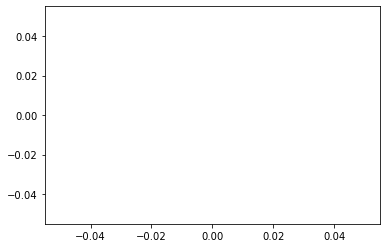

In [3]:
from scipy.stats import spearmanr

plt.figure()
v="mu_cape"
plt.scatter(barra_df[v], era5_df[v], marker="x", s=60)
plt.plot([np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], [np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], ls="--", color="k")
plt.title("CAPE: r = "+str(spearmanr(barra_df[v], era5_df[v]).correlation.round(3)))
plt.xlabel("BARRA"); plt.ylabel("ERA5")

plt.figure()
v="s06"
plt.scatter(barra_df[v], era5_df[v], marker="x", s=60)
plt.plot([np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], [np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], ls="--", color="k")
plt.title("S06: r = "+str(spearmanr(barra_df[v], era5_df[v]).correlation.round(3)))
plt.xlabel("BARRA"); plt.ylabel("ERA5")

plt.figure()
v="dcape"
plt.scatter(barra_df[v], era5_df[v], marker="x", s=60)
plt.plot([np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], [np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], ls="--", color="k")
plt.title("DCAPE: r = "+str(spearmanr(barra_df[v], era5_df[v]).correlation.round(3)))
plt.xlabel("BARRA"); plt.ylabel("ERA5")

plt.figure()
v="Umean06"
plt.scatter(barra_df[v], era5_df[v], marker="x", s=60)
plt.plot([np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], [np.min([barra_df[v], era5_df[v]]), np.max([barra_df[v], era5_df[v]])], ls="--", color="k")
plt.title("UMean06: r = "+str(spearmanr(barra_df[v], era5_df[v]).correlation.round(3)))
plt.xlabel("BARRA"); plt.ylabel("ERA5")